In [25]:
import plotly.offline as pyo
pyo.init_notebook_mode()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2 
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn import preprocessing
import random
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
!pip install visualkeras
!pip install pydicom
import pydicom as dicom
import os
import numpy
from matplotlib import pyplot, cm
base = '../input/brain-tumor/MAR 2020 MRI_AXIAL-20220125T052758Z-001/MAR 2020 MRI_AXIAL-20220125T052758Z-001/MAR 2020 MRI_AXIAL/AD/AD_AXIAL_MRI/AD_AXIAL_01'
lt = os.listdir(base)

In [26]:
def create_df():
    main = '../input/brain-tumor/MAR 2020 MRI_AXIAL-20220125T052758Z-001/MAR 2020 MRI_AXIAL-20220125T052758Z-001/MAR 2020 MRI_AXIAL/'
    df = pd.DataFrame()
    for Class in os.listdir(main):
        for axial in os.listdir(main+'/'+Class):
            for patient in os.listdir(main+'/'+Class+'/'+axial):
                for image in os.listdir(main+'/'+Class+'/'+axial+'/'+patient):
                    df = df.append({
                        'Category':Class,
                        'type':axial,
                        'patient':patient,
                        'location':main+'/'+Class+'/'+axial+'/'+patient+'/'+image,
                    },ignore_index = True)
    return df
df = create_df()
df = df.groupby('Category').apply(lambda x: x.sample(3000)).reset_index(drop=True)
df.groupby(['Category']).count()

type  patient  location
Category                         
AD        3000     3000      3000
CN        3000     3000      3000
MCI       3000     3000      3000

In [27]:
w , h= 128,128
final_class = len(np.unique(df['Category']))
w,h ,final_class

(128, 128, 3)

In [28]:
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
import imageio
left = []
y = []
for ind in tqdm(df.index):
    ds = imageio.imread(df.loc[ind,'location'])
    img = np.array(ds)
    if img.shape == (128,128):
        continue
    img = cv2.resize(img, (w,h), interpolation = cv2.INTER_AREA)
    img = img.reshape(w,h,1)
    left.append(img)
    y.append(df.loc[ind,'Category'])
X = np.array(left)
y = np.array(y)
y = y.reshape(y.shape[0],1)
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y)
# print(enc.categories_)
y = enc.transform(y).toarray()
print('Data   :   '+str(X.shape))
print('Output :   '+str(y.shape))

100%|██████████| 9000/9000 [00:24<00:00, 362.04it/s]


Data   :   (7117, 128, 128, 1)
Output :   (7117, 3)


In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
print('Train data    :'+str(X_train.shape))
print('Test data     :'+str(X_test.shape))
print('Train Output  :'+str(y_train.shape))
print('Test Output   :'+str(y_test.shape))

Train data    :(5693, 128, 128, 1)
Test data     :(1424, 128, 128, 1)
Train Output  :(5693, 3)
Test Output   :(1424, 3)


# VGG

In [30]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import  metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.nasnet import NASNetMobile # NASNetMobile
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [31]:
input1 = Input(shape=(X.shape[1],X.shape[2],1,))
FE_sigma_X = Conv2D(3, kernel_size=3, padding ='same', activation='relu')(input1)
FE_sigma_X = VGG16(input_shape=(X.shape[1],X.shape[2],3), weights='imagenet', include_top=False)(FE_sigma_X)
FE_sigma_X_OP = Flatten()(FE_sigma_X)
FE_sigma_X_OP = Dense(1024)(FE_sigma_X_OP)
model_FV = Model(inputs=input1,outputs=FE_sigma_X_OP)


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 3)       30        
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              8389632   
Total params: 23,104,350
Trainable params: 23,104,350
Non-trainable params: 0
_________________________________________________________________
None


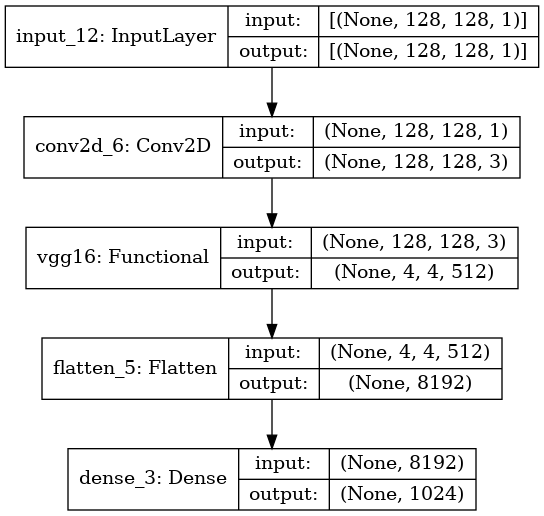

In [32]:
print(model_FV.summary())
tf.keras.utils.plot_model(model_FV, show_shapes=True)

In [33]:
FE_X_OP = model_FV.predict(X)

# ML

In [43]:
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import model_selection
from sklearn.metrics import accuracy_score, log_loss
import sklearn
import string
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import roc_curve, auc, roc_auc_score,accuracy_score,confusion_matrix
import warnings
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import  metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
import seaborn as sns
warnings.filterwarnings("ignore")
def multiclass_roc_auc_score(y_test, y_pred, name,  average="macro"):
    fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    target= list(np.unique(Y_op))
    print(target)
    matplotlib.rcParams.update({'font.size': 12})
    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate',fontsize = 26)
    c_ax.set_ylabel('True Positive Rate',fontsize = 26)
    
    plt.savefig('ROC_AUC__'+name+'.jpeg')
    plt.show()
    return roc_auc_score(y_test, y_pred, average=average)

def onevsall(y_true,y_pred,mod,types):
    
    
    global rdf
    df = pd.DataFrame()
    lb = LabelBinarizer()
    lb.fit(y_true)
    y_test = lb.transform(y_true)
    y_pred = lb.transform(y_pred)
    target= list(np.unique(Y_op))
    df = pd.DataFrame()
    ACC = 0
    PRE = 0
    REC = 0
    F1 = 0
    SP = 0
    for (idx, c_label) in enumerate(target):
        tn, fp, fn, tp = confusion_matrix(y_test[:,idx].astype(int), y_pred[:,idx]).ravel()
        acc = (tp+tn)/(tp+tn+fp+fn)
        ACC += acc
        pre = tp/(tp+fp)
        PRE += pre
        rec = tp/(tp+fn)
        REC += rec
        f1 = 2*rec*pre / (rec +pre)
        F1 += f1
        sp = tn / (tn +fp)
        SP += sp
        df=df.append({
            'Class':c_label,
            'TN':tn,'FP':fp,'FN':fn,'TP':tp,
            'Accuracy':acc,
            'Precision':pre,
            'Recall or Sensitivity':rec,
            'F1 Score':f1,
            'Specificity':sp
        },ignore_index=True)
    df.to_csv(mod+'.csv')
    global rdf
    rdf=rdf.append({
            'Model':mod,
            'SPlit':types,
            'TN':tn,'FP':fp,'FN':fn,'TP':tp,
            'Accuracy':ACC / len(target),
            'Precision':PRE / len(target),
            'Recall or Sensitivity':REC / len(target),
            'F1 Score':F1 / len(target),
            'Specificity':SP / len(target)
        },ignore_index=True)
        
    return rdf
def roc(clf,x,y):
    import scikitplot as skplt
    import matplotlib.pyplot as plt
    skplt.metrics.plot_roc_curve(clf,x,y)
    plt.savefig('ROC'+model_name+'.jpg')
    plt.show()


def visualise(y_true,y_pred,name,model_name,subset,types):
    ConfusionM = confusion_matrix(y_true,y_pred)
    
    print('***********************'+types+'*********************************')
    print('ROC AUC score:', 
    multiclass_roc_auc_score(y_true,y_pred, model_name + '__'+subset))
    print(classification_report(y_true,y_pred,   digits=4))
    print()
    fig, ax = plt.subplots(figsize=(10,10)) 
    sns.heatmap(ConfusionM, annot=True,
            fmt='g',xticklabels=name, yticklabels=name)
    plt.title('Confusion Matrix for '+model_name)
    plt.savefig('CM_'+model_name + '__'+subset+'.jpg')
    plt.show()
    return onevsall(y_true,y_pred,model_name,types)

def run(clf,X_train, y_train,X_test,y_test,subset):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_true = y_test
    name = np.unique(y_train)
    _, X_test, _, y_test = train_test_split( X_test, y_test, test_size=0.2)
    visualise(y_test,clf.predict(X_test),name,clf.__class__.__name__,subset,'Test')
    print()
    print()
    print()
    visualise(y_train,clf.predict(X_train),name,clf.__class__.__name__,subset,'Train')
    print()
    print()
    print()
def RNDF(X_train, y_train,sel_x,y,subset ):
    for clf in tqdm(models_f1):
        print(clf.__class__.__name__)
        #
        run(clf,X_train, y_train,sel_x,y,subset)
    return rdf

In [45]:
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
rdf = pd.DataFrame()
models_f1 = []
models_f1.append((KNeighborsClassifier(n_neighbors=5, 
                                       weights='uniform', algorithm='auto', 
                                       leaf_size=25, p=2, metric='minkowski',
                                       metric_params=None, n_jobs=None)))
models_f1.append((RandomForestClassifier(n_estimators=71, criterion='gini', max_depth=None, 
                                         min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                         max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                         bootstrap=True, oob_score=False, n_jobs=None, random_state=None, 
                                         verbose=0, warm_start=False, class_weight=None)))
models_f1.append((DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, 
                                         min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                         max_features=None, random_state=None, 
                                         max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                         class_weight=None, ccp_alpha=0.0)))
models_f1.append(LogisticRegression())
models_f1.append((AdaBoostClassifier(base_estimator=None,  n_estimators=50, 
                                     learning_rate=1.0, algorithm='SAMME.R', 
                                     random_state=None)))
models_f1.append(xgb.XGBClassifier(max_depth = 2,n_estimators=10))
models_f1.append(GaussianNB())
models_f1 

[KNeighborsClassifier(leaf_size=25),
 RandomForestClassifier(max_features='sqrt', n_estimators=71),
 DecisionTreeClassifier(),
 LogisticRegression(),
 AdaBoostClassifier(),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, gamma=None,
               gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, n_estimators=10, n_jobs=None,
               num_parallel_tree=None, predictor=None, random_state=None,
               reg_alpha=None, reg_lambda=None, ...),
 GaussianNB()]

In [36]:
from sklearn import preprocessing
yop=[]
for i in y:
    yop.append(str(i))
le = preprocessing.LabelEncoder()
Y_op = le.fit_transform(yop)
le.classes_

array(['[0. 0. 1.]', '[0. 1. 0.]', '[1. 0. 0.]'], dtype='<U10')

In [37]:
from tqdm import tqdm
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [40]:
rdf = pd.DataFrame()
dfvgg = pd.DataFrame(FE_X_OP)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dfvgg, Y_op, random_state=42, test_size=0.2)
print('Train data    :'+str(X_train.shape))
print('Test data     :'+str(X_test.shape))
print('Train Output  :'+str(y_train.shape))
print('Test Output   :'+str(y_test.shape))

Train data    :(5693, 1024)
Test data     :(1424, 1024)
Train Output  :(5693,)
Test Output   :(1424,)


  0%|          | 0/7 [00:00<?, ?it/s]

KNeighborsClassifier
***********************Test*********************************
[0, 1, 2]


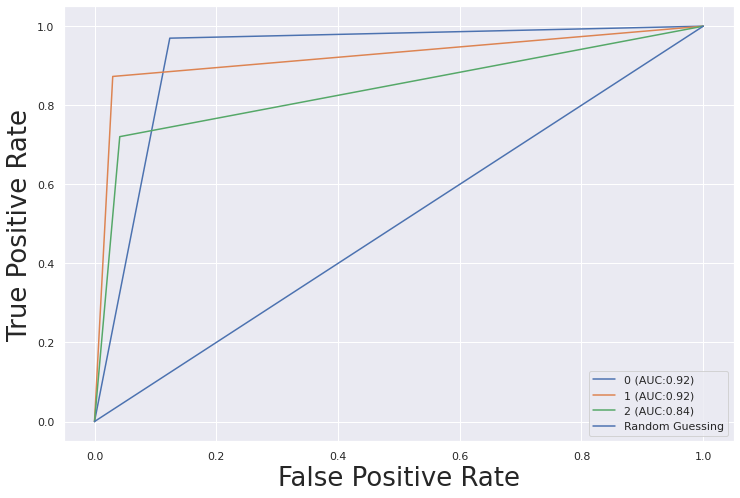

ROC AUC score: 0.8946826454677396
              precision    recall  f1-score   support

           0     0.8067    0.9697    0.8807        99
           1     0.9537    0.8729    0.9115       118
           2     0.8448    0.7206    0.7778        68

    accuracy                         0.8702       285
   macro avg     0.8684    0.8544    0.8567       285
weighted avg     0.8767    0.8702    0.8689       285




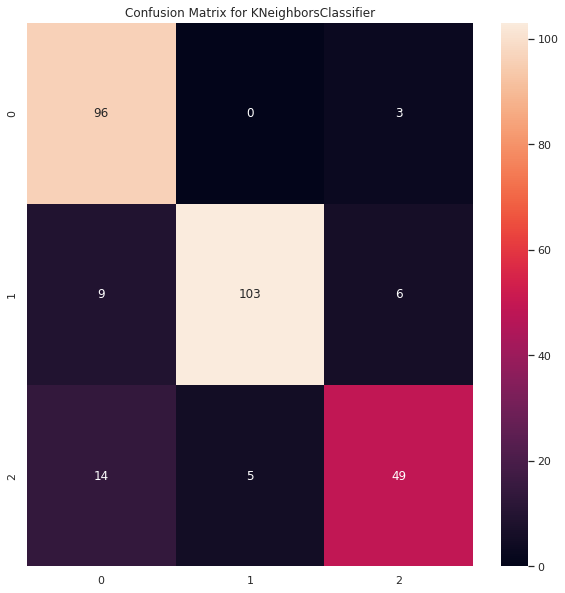




***********************Train*********************************
[0, 1, 2]


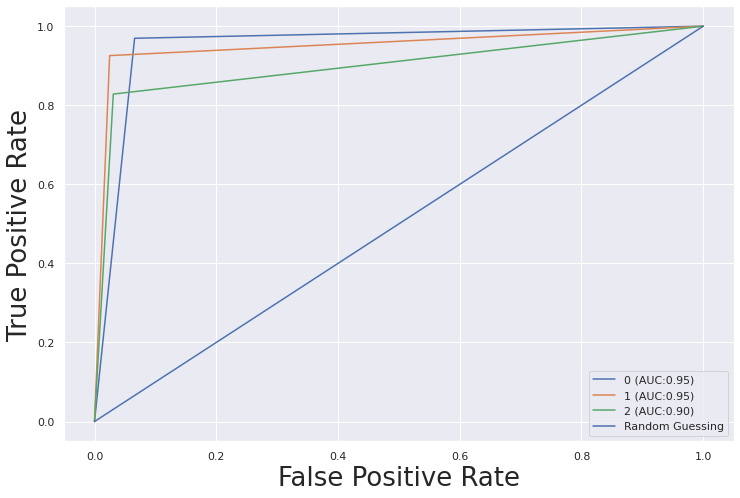

ROC AUC score: 0.9336221575870732
              precision    recall  f1-score   support

           0     0.8955    0.9695    0.9310      2095
           1     0.9622    0.9256    0.9435      2311
           2     0.8869    0.8283    0.8566      1287

    accuracy                         0.9197      5693
   macro avg     0.9149    0.9078    0.9104      5693
weighted avg     0.9206    0.9197    0.9193      5693




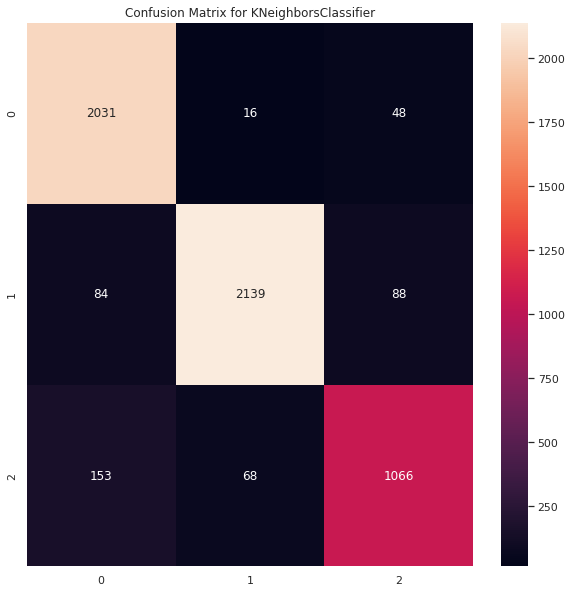

 14%|█▍        | 1/7 [00:05<00:30,  5.04s/it]




RandomForestClassifier
***********************Test*********************************
[0, 1, 2]


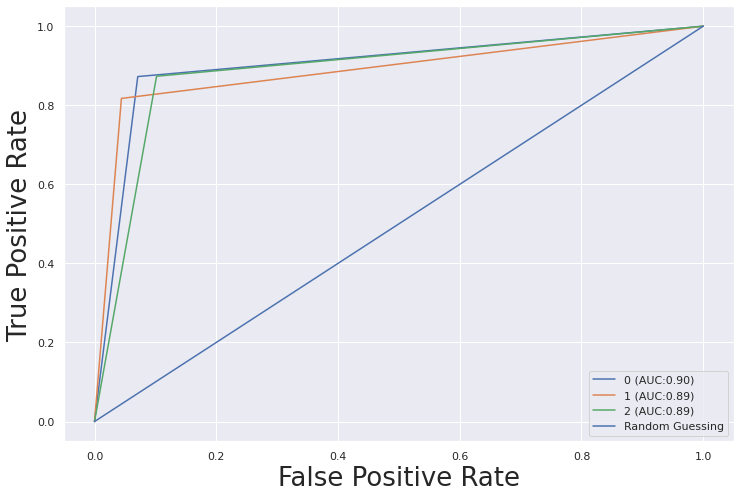

ROC AUC score: 0.8910159232446606
              precision    recall  f1-score   support

           0     0.8725    0.8725    0.8725       102
           1     0.9140    0.8173    0.8629       104
           2     0.7667    0.8734    0.8166        79

    accuracy                         0.8526       285
   macro avg     0.8511    0.8544    0.8507       285
weighted avg     0.8583    0.8526    0.8535       285




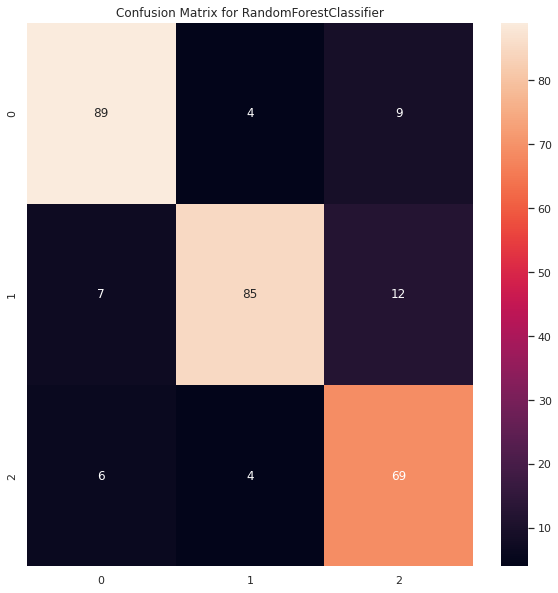




***********************Train*********************************
[0, 1, 2]


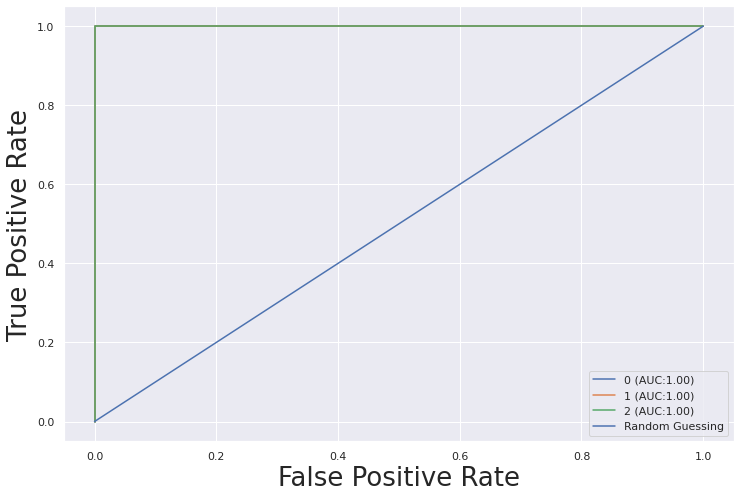

ROC AUC score: 1.0
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      2095
           1     1.0000    1.0000    1.0000      2311
           2     1.0000    1.0000    1.0000      1287

    accuracy                         1.0000      5693
   macro avg     1.0000    1.0000    1.0000      5693
weighted avg     1.0000    1.0000    1.0000      5693




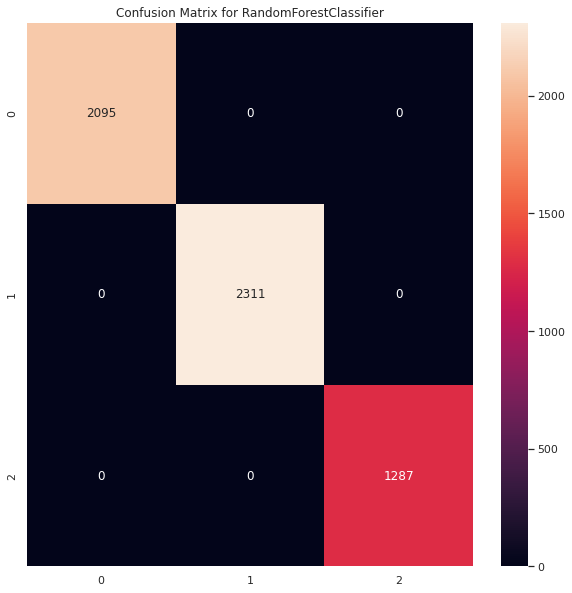

 29%|██▊       | 2/7 [00:16<00:44,  8.97s/it]




DecisionTreeClassifier
***********************Test*********************************
[0, 1, 2]


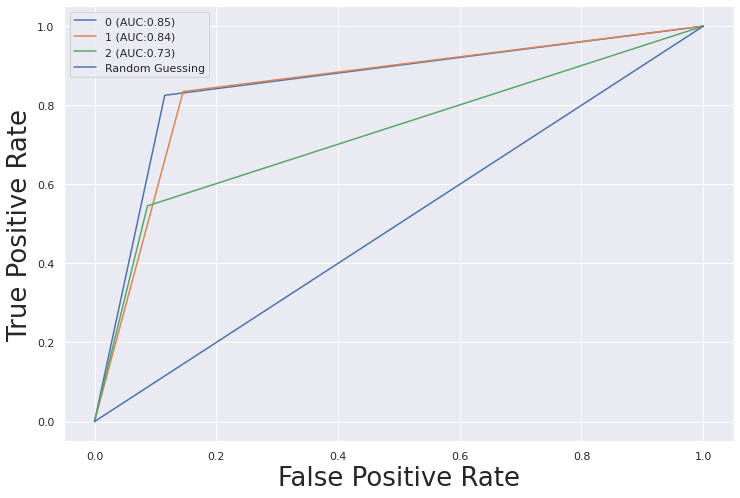

ROC AUC score: 0.809572029302596
              precision    recall  f1-score   support

           0     0.8019    0.8252    0.8134       103
           1     0.8217    0.8346    0.8281       127
           2     0.6000    0.5455    0.5714        55

    accuracy                         0.7754       285
   macro avg     0.7412    0.7351    0.7377       285
weighted avg     0.7718    0.7754    0.7733       285




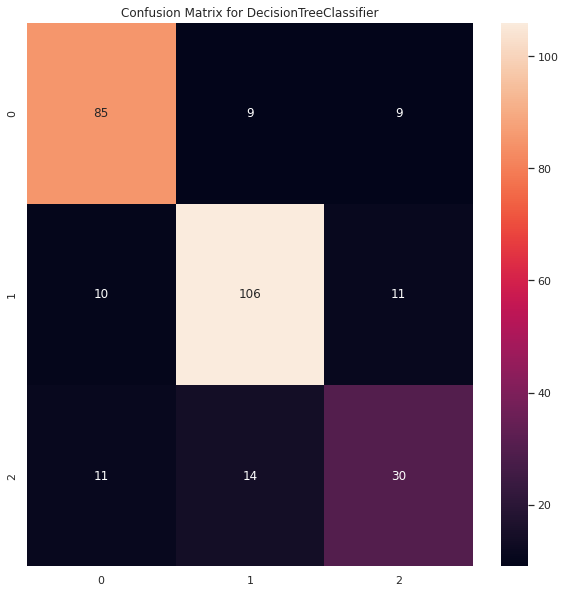




***********************Train*********************************
[0, 1, 2]


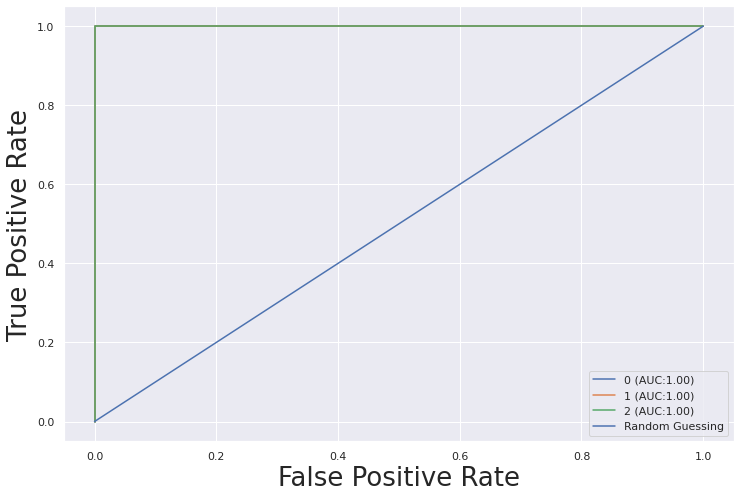

ROC AUC score: 1.0
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      2095
           1     1.0000    1.0000    1.0000      2311
           2     1.0000    1.0000    1.0000      1287

    accuracy                         1.0000      5693
   macro avg     1.0000    1.0000    1.0000      5693
weighted avg     1.0000    1.0000    1.0000      5693




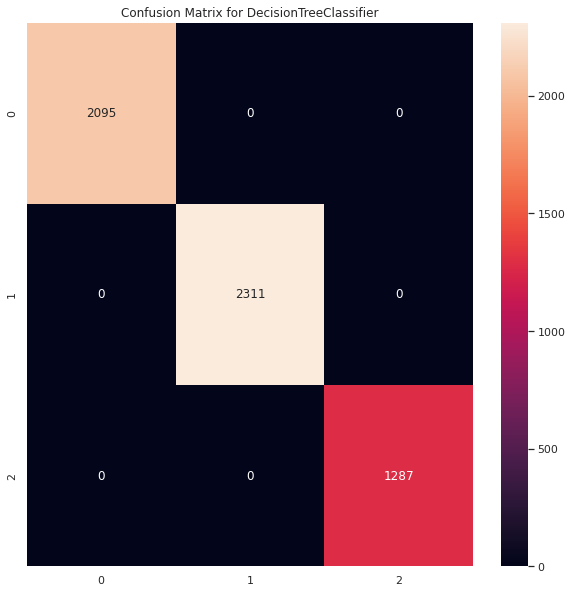

 43%|████▎     | 3/7 [00:26<00:36,  9.12s/it]




LogisticRegression
***********************Test*********************************
[0, 1, 2]


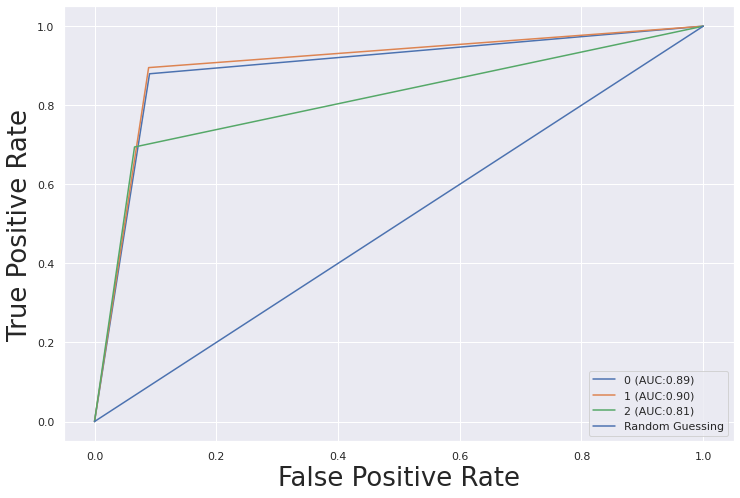

ROC AUC score: 0.8707166834444625
              precision    recall  f1-score   support

           0     0.8559    0.8796    0.8676       108
           1     0.8545    0.8952    0.8744       105
           2     0.7812    0.6944    0.7353        72

    accuracy                         0.8386       285
   macro avg     0.8306    0.8231    0.8258       285
weighted avg     0.8365    0.8386    0.8367       285




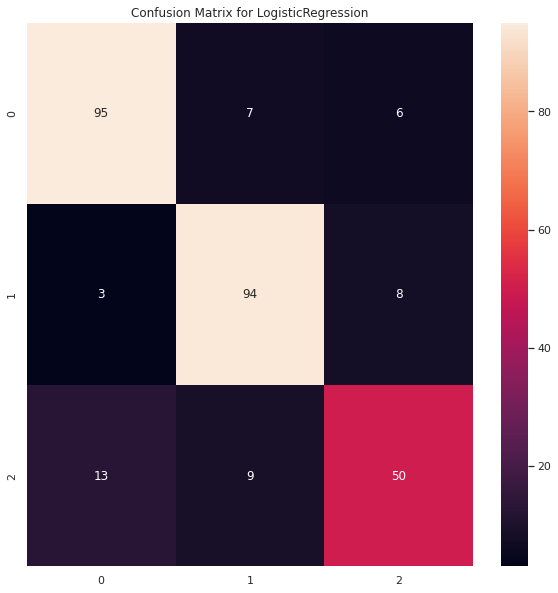




***********************Train*********************************
[0, 1, 2]


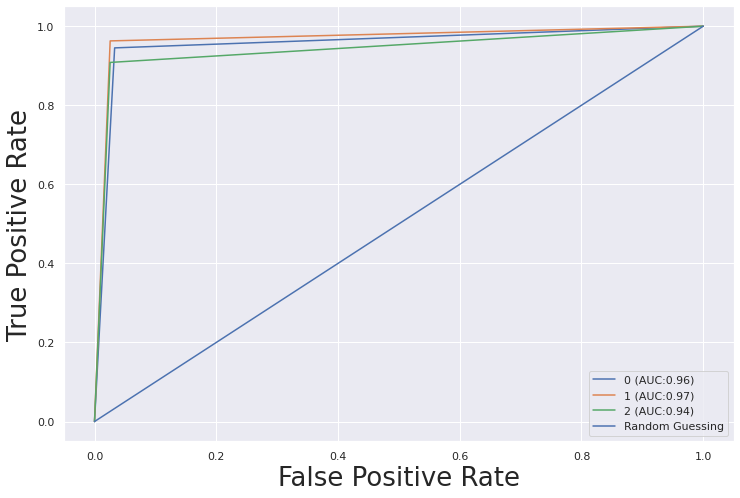

ROC AUC score: 0.9552937967879735
              precision    recall  f1-score   support

           0     0.9433    0.9451    0.9442      2095
           1     0.9624    0.9628    0.9626      2311
           2     0.9119    0.9083    0.9101      1287

    accuracy                         0.9440      5693
   macro avg     0.9392    0.9387    0.9390      5693
weighted avg     0.9439    0.9440    0.9439      5693




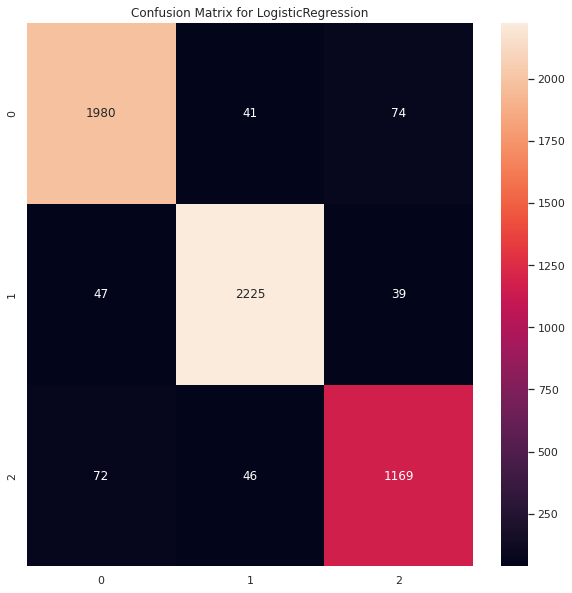

 57%|█████▋    | 4/7 [00:30<00:21,  7.12s/it]




AdaBoostClassifier
***********************Test*********************************
[0, 1, 2]


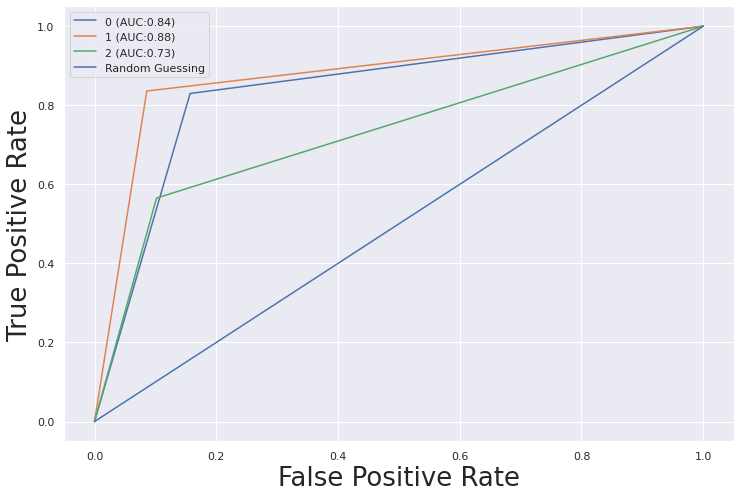

ROC AUC score: 0.8143767856476947
              precision    recall  f1-score   support

           0     0.7222    0.8298    0.7723        94
           1     0.8793    0.8361    0.8571       122
           2     0.6393    0.5652    0.6000        69

    accuracy                         0.7684       285
   macro avg     0.7470    0.7437    0.7431       285
weighted avg     0.7694    0.7684    0.7669       285




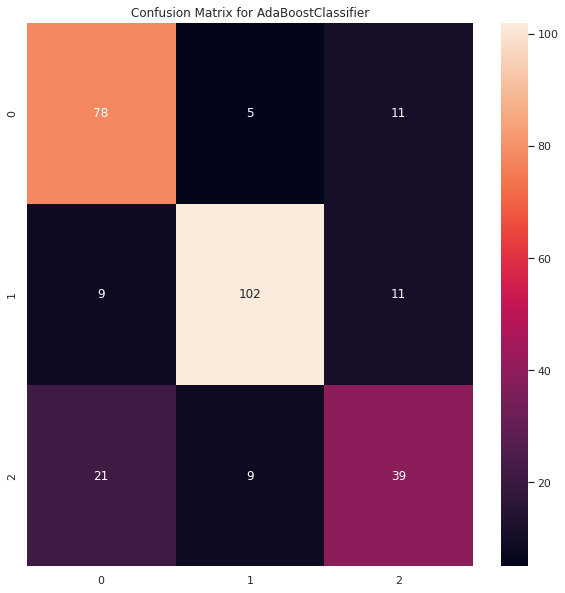




***********************Train*********************************
[0, 1, 2]


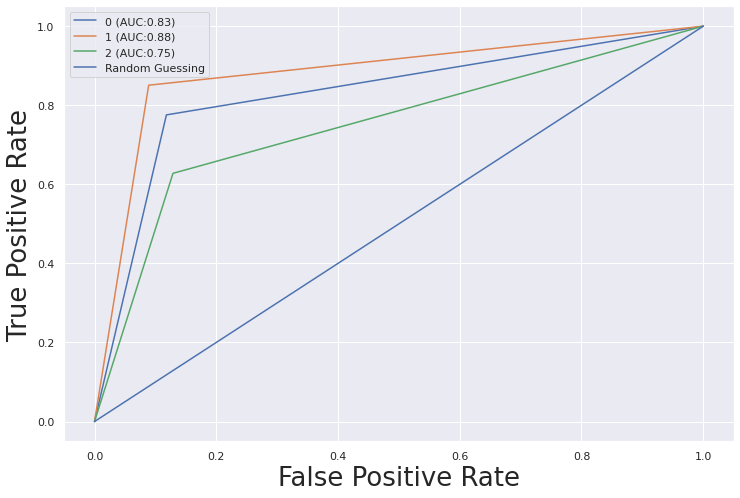

ROC AUC score: 0.819691673913782
              precision    recall  f1-score   support

           0     0.7927    0.7757    0.7841      2095
           1     0.8672    0.8507    0.8589      2311
           2     0.5872    0.6278    0.6068      1287

    accuracy                         0.7727      5693
   macro avg     0.7490    0.7514    0.7499      5693
weighted avg     0.7765    0.7727    0.7744      5693




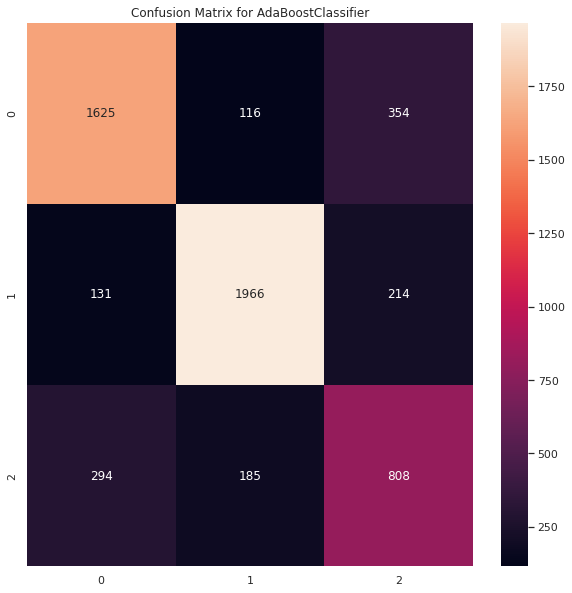

 71%|███████▏  | 5/7 [01:08<00:36, 18.48s/it]




XGBClassifier
***********************Test*********************************
[0, 1, 2]


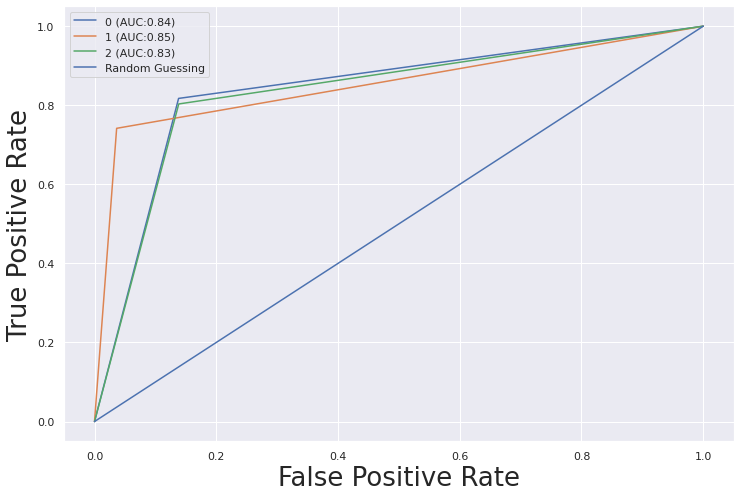

ROC AUC score: 0.8415625011718548
              precision    recall  f1-score   support

           0     0.7727    0.8173    0.7944       104
           1     0.9368    0.7417    0.8279       120
           2     0.6125    0.8033    0.6950        61

    accuracy                         0.7825       285
   macro avg     0.7740    0.7874    0.7724       285
weighted avg     0.8075    0.7825    0.7872       285




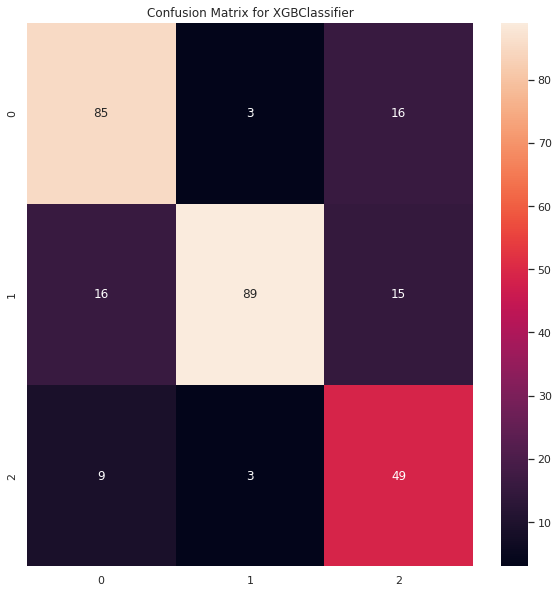




***********************Train*********************************
[0, 1, 2]


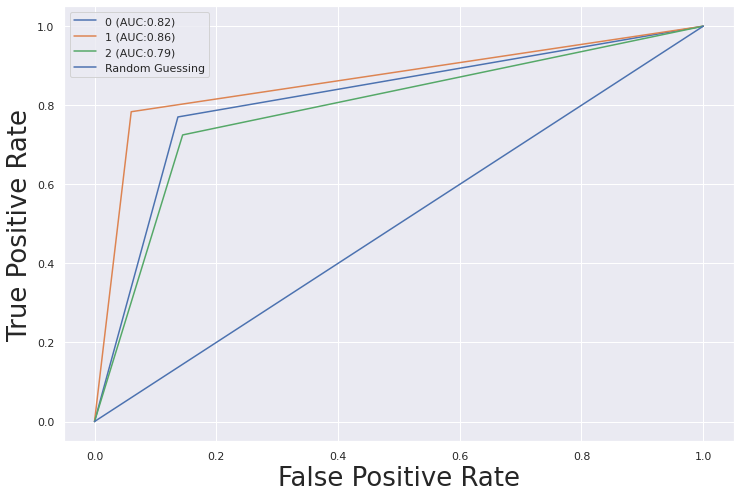

ROC AUC score: 0.822808075103641
              precision    recall  f1-score   support

           0     0.7660    0.7704    0.7682      2095
           1     0.8988    0.7836    0.8373      2311
           2     0.5939    0.7249    0.6529      1287

    accuracy                         0.7655      5693
   macro avg     0.7529    0.7597    0.7528      5693
weighted avg     0.7810    0.7655    0.7702      5693




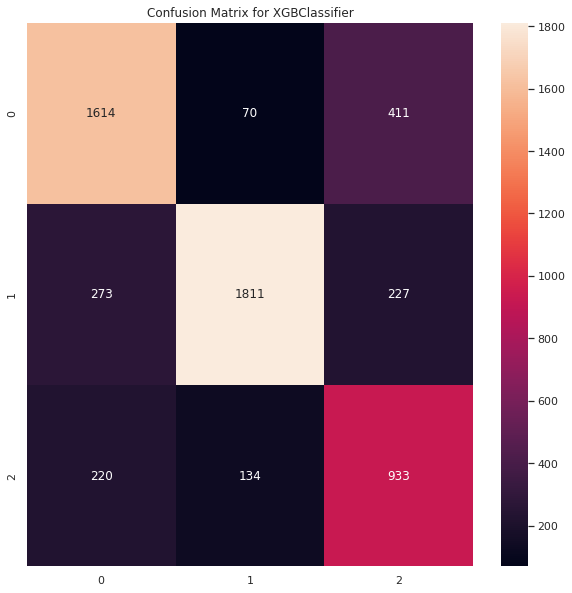

 86%|████████▌ | 6/7 [01:23<00:17, 17.17s/it]




GaussianNB
***********************Test*********************************
[0, 1, 2]


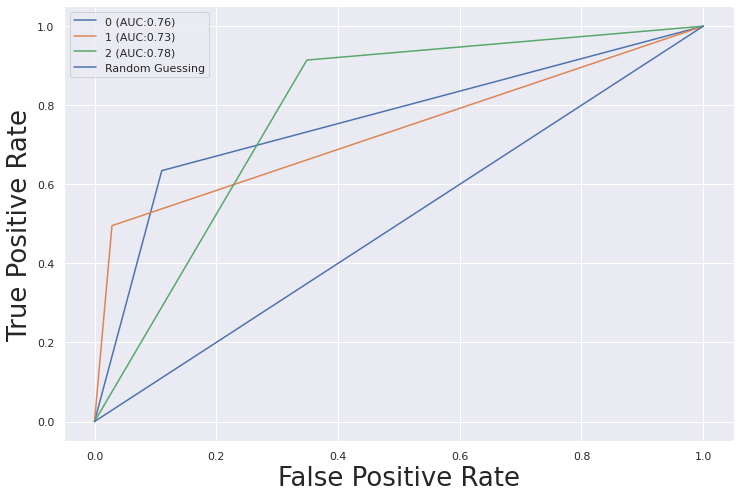

ROC AUC score: 0.7593877525568834
              precision    recall  f1-score   support

           0     0.7674    0.6346    0.6947       104
           1     0.9167    0.4955    0.6433       111
           2     0.4604    0.9143    0.6124        70

    accuracy                         0.6491       285
   macro avg     0.7148    0.6815    0.6502       285
weighted avg     0.7502    0.6491    0.6545       285




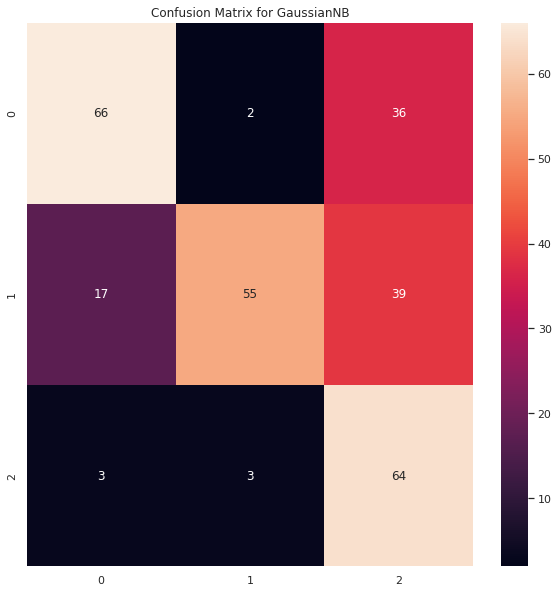




***********************Train*********************************
[0, 1, 2]


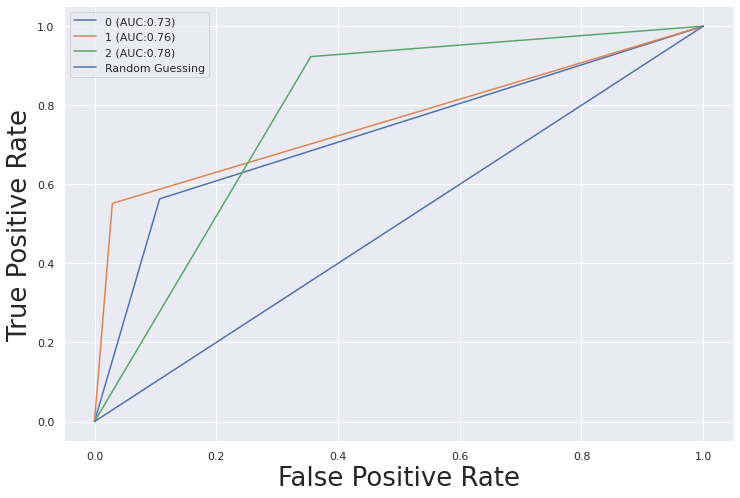

ROC AUC score: 0.7577218385348742
              precision    recall  f1-score   support

           0     0.7540    0.5632    0.6448      2095
           1     0.9279    0.5517    0.6920      2311
           2     0.4314    0.9231    0.5880      1287

    accuracy                         0.6399      5693
   macro avg     0.7044    0.6793    0.6416      5693
weighted avg     0.7517    0.6399    0.6511      5693




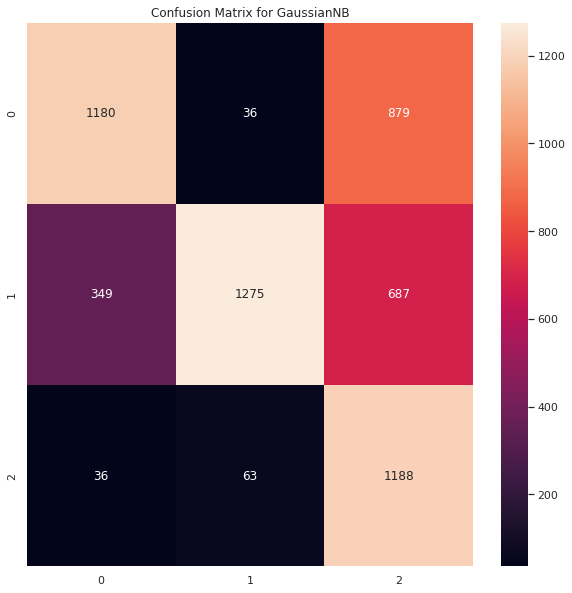

100%|██████████| 7/7 [01:24<00:00, 12.14s/it]

Model  SPlit      TN      FP     FN      TP  Accuracy  \
0     KNeighborsClassifier   Test   208.0     9.0   19.0    49.0  0.913450   
1     KNeighborsClassifier  Train  4270.0   136.0  221.0  1066.0  0.946484   
2   RandomForestClassifier   Test   185.0    21.0   10.0    69.0  0.901754   
3   RandomForestClassifier  Train  4406.0     0.0    0.0  1287.0  1.000000   
4   DecisionTreeClassifier   Test   210.0    20.0   25.0    30.0  0.850292   
5   DecisionTreeClassifier  Train  4406.0     0.0    0.0  1287.0  1.000000   
6       LogisticRegression   Test   199.0    14.0   22.0    50.0  0.892398   
7       LogisticRegression  Train  4293.0   113.0  118.0  1169.0  0.962644   
8       AdaBoostClassifier   Test   194.0    22.0   30.0    39.0  0.845614   
9       AdaBoostClassifier  Train  3838.0   568.0  479.0   808.0  0.848469   
10           XGBClassifier   Test   193.0    31.0   12.0    49.0  0.854971   
11           XGBClassifier  Train  3768.0   638.0  354.0   933.0  0.843668   
12              GaussianNB   Test   140.0    75.0    6.0    64.0  0.766082   
13              GaussianNB  Train  2840.0  1566.0   99.0  1188.0  0.759939   

    Precision  Recall or Sensitivity  F1 Score  Specificity  
0    0.868418               0.854389  0.856672     0.934976  
1    0.914857               0.907769  0.910372     0.959475  
2    0.851065               0.854425  0.850687     0.927607  
3    1.000000               1.000000  1.000000     1.000000  
4    0.741197               0.735114  0.737650     0.884030  
5    1.000000               1.000000  1.000000     1.000000  
6    0.830550               0.823104  0.825764     0.918329  
7    0.939178               0.938736  0.938955     0.971852  
8    0.746959               0.743690  0.743140     0.885064  
9    0.749039               0.751396  0.749934     0.887988  
10   0.774023               0.787418  0.772445     0.895707  
11   0.752889               0.759664  0.752791     0.885953  
12   0.714847               0.681466  0.650151     0.837310  
13   0.704438               0.679344  0.641592     0.836100

In [46]:
RNDF(X_train, y_train,X_test,y_test,'VGG_Fex_DF__')

In [49]:
rdf.groupby(['Model','SPlit']).mean()

TN      FP     FN      TP  Accuracy  \
Model                  SPlit                                            
AdaBoostClassifier     Test    194.0    22.0   30.0    39.0  0.845614   
                       Train  3838.0   568.0  479.0   808.0  0.848469   
DecisionTreeClassifier Test    210.0    20.0   25.0    30.0  0.850292   
                       Train  4406.0     0.0    0.0  1287.0  1.000000   
GaussianNB             Test    140.0    75.0    6.0    64.0  0.766082   
                       Train  2840.0  1566.0   99.0  1188.0  0.759939   
KNeighborsClassifier   Test    208.0     9.0   19.0    49.0  0.913450   
                       Train  4270.0   136.0  221.0  1066.0  0.946484   
LogisticRegression     Test    199.0    14.0   22.0    50.0  0.892398   
                       Train  4293.0   113.0  118.0  1169.0  0.962644   
RandomForestClassifier Test    185.0    21.0   10.0    69.0  0.901754   
                       Train  4406.0     0.0    0.0  1287.0  1.000000   
XGBClassifier          Test    193.0    31.0   12.0    49.0  0.854971   
                       Train  3768.0   638.0  354.0   933.0  0.843668   

                              Precision  Recall or Sensitivity  F1 Score  \
Model                  SPlit                                               
AdaBoostClassifier     Test    0.746959               0.743690  0.743140   
                       Train   0.749039               0.751396  0.749934   
DecisionTreeClassifier Test    0.741197               0.735114  0.737650   
                       Train   1.000000               1.000000  1.000000   
GaussianNB             Test    0.714847               0.681466  0.650151   
                       Train   0.704438               0.679344  0.641592   
KNeighborsClassifier   Test    0.868418               0.854389  0.856672   
                       Train   0.914857               0.907769  0.910372   
LogisticRegression     Test    0.830550               0.823104  0.825764   
                       Train   0.939178               0.938736  0.938955   
RandomForestClassifier Test    0.851065               0.854425  0.850687   
                       Train   1.000000               1.000000  1.000000   
XGBClassifier          Test    0.774023               0.787418  0.772445   
                       Train   0.752889               0.759664  0.752791   

                              Specificity  
Model                  SPlit               
AdaBoostClassifier     Test      0.885064  
                       Train     0.887988  
DecisionTreeClassifier Test      0.884030  
                       Train     1.000000  
GaussianNB             Test      0.837310  
                       Train     0.836100  
KNeighborsClassifier   Test      0.934976  
                       Train     0.959475  
LogisticRegression     Test      0.918329  
                       Train     0.971852  
RandomForestClassifier Test      0.927607  
                       Train     1.000000  
XGBClassifier          Test      0.895707  
                       Train     0.885953

# CrossValidation

In [55]:
X_test = X_test.reset_index(drop = True)
X_test

0           1           2           3           4           5     \
0     171.422546  -16.271202   -4.921040   -2.995752 -110.229294  -53.892082   
1      -8.562318   31.562336   19.666819   28.823477    4.217339   12.695921   
2      34.427818  -14.642569   12.098841   -0.933552   -4.308239  -16.338335   
3      20.635828  -31.003220   61.285210   -8.905283  -89.962891  -29.433449   
4      -1.571550   13.283904   13.366465   24.765512   -1.035378   -3.483217   
...          ...         ...         ...         ...         ...         ...   
1419    2.322453  -12.727118   37.352844   10.667397   43.793026  -37.451271   
1420   29.369843   -5.093693   26.458181   18.151161  -16.027493  -56.318958   
1421  394.398163 -160.902588  391.987762  290.553650 -214.043884  271.725891   
1422    6.102691    2.309421    3.071924   38.284950    4.575779  -36.363358   
1423    6.111638   22.000443   18.091707  -21.610964  -23.743328  -10.208550   

            6           7           8          9     ...        1014  \
0    -141.125488 -108.891487  -22.598160 -72.107040  ...   55.787842   
1      -4.216707   11.987564  -13.266919   2.223670  ...   -2.541279   
2     -37.597580    4.991896   52.773087  29.397333  ...   -1.611856   
3     -27.985624  -13.451097   55.045937  -0.553925  ...   -2.837574   
4      11.079250    9.001978   13.901363 -21.172287  ...   -5.584934   
...          ...         ...         ...        ...  ...         ...   
1419  -28.165012  -22.740831   10.393770 -11.506618  ...   -2.379319   
1420  -14.259796   11.509575    3.090885  -0.362256  ...  -55.718533   
1421 -525.860413 -111.130119  288.151917  -1.015717  ... -212.524841   
1422  -19.671307    6.343356   11.532764 -41.660202  ...   -7.776045   
1423   29.187191    7.273163   -4.549765   9.711275  ...   -4.185571   

            1015        1016        1017        1018        1019        1020  \
0    -103.174820   64.085197  -41.736355 -117.687698 -111.548943  -77.664864   
1      16.697758    4.577235   21.312069  -54.672260   -8.891708   13.467271   
2     -25.449625    4.903275  -17.398478   21.284012    3.674042   10.673388   
3     -47.324429   27.777685   -8.259008  -13.469663   -1.728702  -17.384592   
4      -7.039512    2.575200   17.453541  -42.481071   -0.138935  -20.645102   
...          ...         ...         ...         ...         ...         ...   
1419  -16.893734   13.758276  -15.966500    5.721176   -1.790560    3.538242   
1420  -40.554958  -19.748566    5.916291    8.646799  -14.493349  -20.597336   
1421   89.023705  251.373566 -296.856781    0.370392 -412.772919 -112.777618   
1422    5.068424  -41.006279  -23.227512  -16.914431   -7.983708  -40.024319   
1423    0.918379   30.882296  -10.043987  -30.547287   30.498734   -9.845487   

            1021        1022        1023  
0      43.405056   53.044655   23.833801  
1      42.491951  -26.227085  -25.126991  
2      14.343840    4.130373   32.191315  
3     114.064560  -35.060223   21.108847  
4      10.429610   14.062053    3.137191  
...          ...         ...         ...  
1419   31.737272  -17.261990   14.278624  
1420   45.507645   -9.440727  -23.194332  
1421  -55.242447 -226.573639 -126.265312  
1422   14.736706   -2.484554   24.629169  
1423   48.440937   21.133781   39.423447  

[1424 rows x 1024 columns]

In [58]:
from sklearn.model_selection import ShuffleSplit
montecarlo_rns = ShuffleSplit(n_splits=10, test_size=0.20, random_state=0)
j = 1
montedf = pd.DataFrame()
for _, test_index in tqdm(montecarlo_rns.split(X_test)):
    X_t = X_test.iloc[test_index,:]
    Y_t = y_test[test_index]
    rdf = pd.DataFrame()
    for clf in models_f1:
        y_pred = clf.predict(X_t)
        onevsall(Y_t,y_pred,clf.__class__.__name__,'Test')
    rdf['Monte_Carlo_iteration']='Iteration_'+str(j)
    montedf = pd.concat([montedf,rdf])
    j = j + 1

10it [00:06,  1.67it/s]


In [59]:
montedf.groupby(['Model']).mean()

TN    FP    FN    TP  Accuracy  Precision  \
Model                                                                  
AdaBoostClassifier      185.3  27.5  28.2  44.0  0.833450   0.732283   
DecisionTreeClassifier  185.4  27.4  33.5  38.7  0.814035   0.702817   
GaussianNB              142.2  70.6   5.9  66.3  0.775205   0.717328   
KNeighborsClassifier    200.1  12.7  21.2  51.0  0.902690   0.845857   
LogisticRegression      197.6  15.2  18.6  53.6  0.900351   0.840552   
RandomForestClassifier  190.6  22.2  13.0  59.2  0.898480   0.838139   
XGBClassifier           178.8  34.0  18.4  53.8  0.838830   0.751132   

                        Recall or Sensitivity  F1 Score  Specificity  
Model                                                                 
AdaBoostClassifier                   0.733325  0.731433     0.876237  
DecisionTreeClassifier               0.701215  0.699886     0.859661  
GaussianNB                           0.690889  0.662141     0.843055  
KNeighborsClassifier                 0.839288  0.839508     0.927531  
LogisticRegression                   0.839302  0.838468     0.925374  
RandomForestClassifier               0.844849  0.839363     0.925945  
XGBClassifier                        0.756701  0.749291     0.882842

In [60]:
montedf.to_csv('CV_ML.csv')

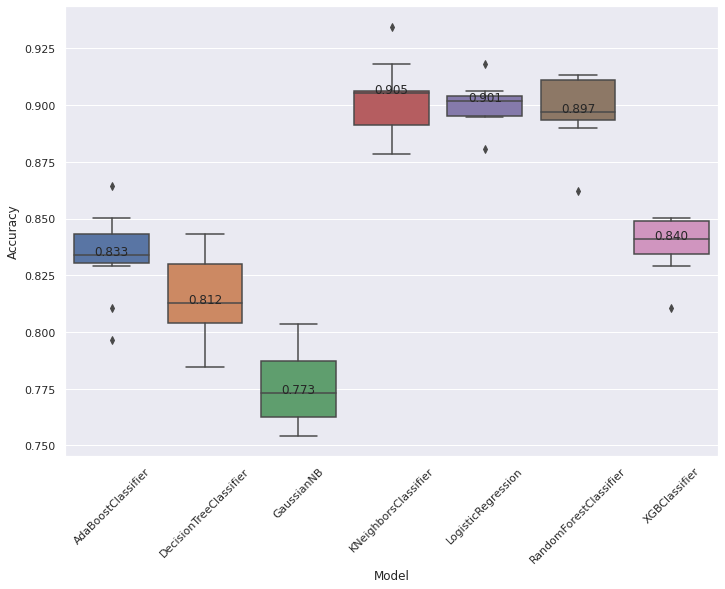

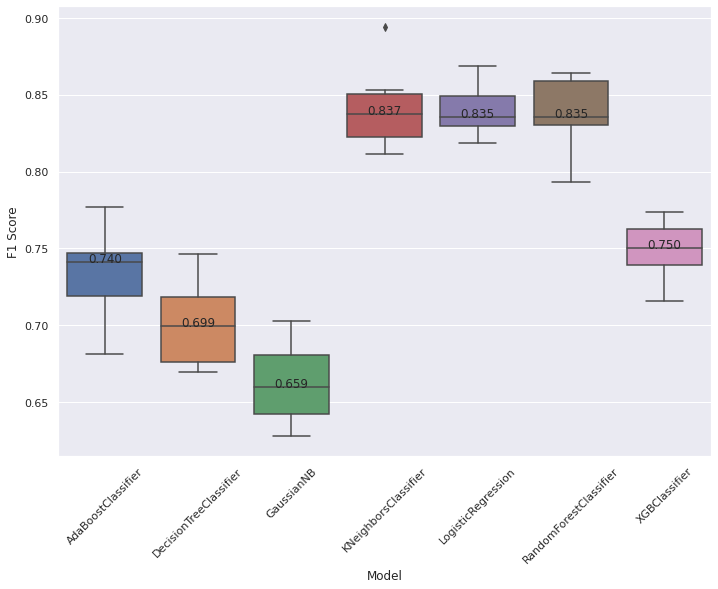

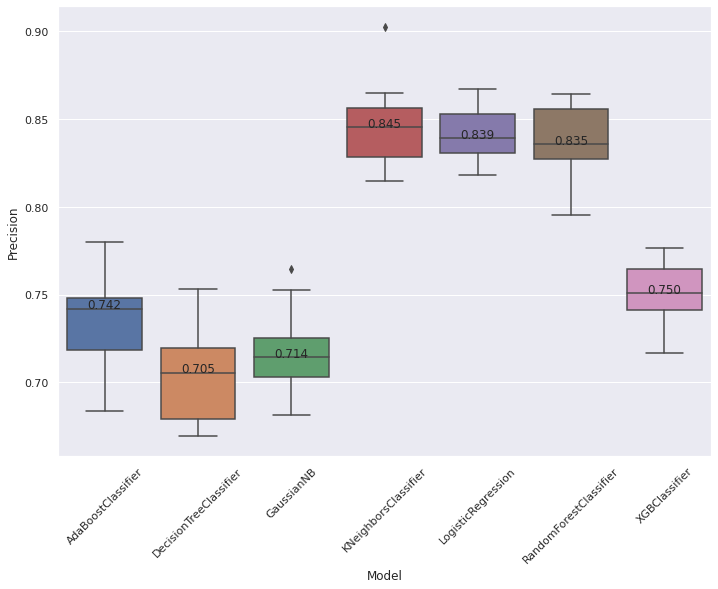

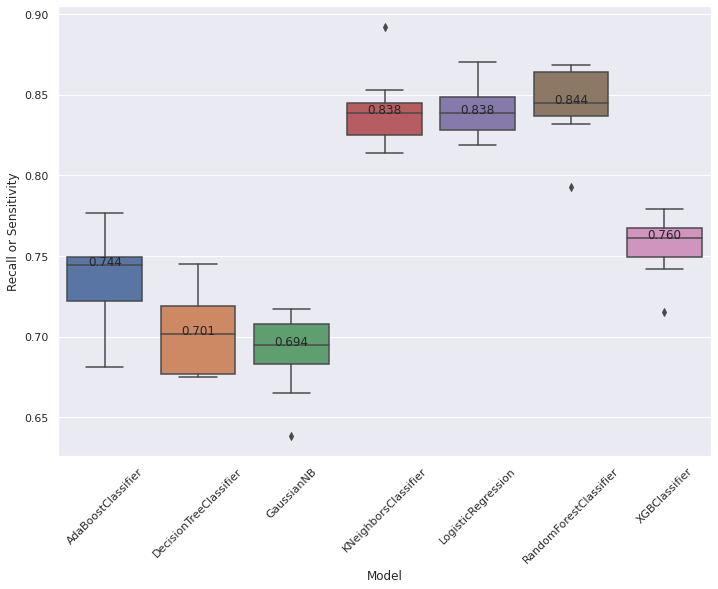

In [62]:
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})
for param in ['Accuracy', 'F1 Score', 'Precision',
       'Recall or Sensitivity',]:
    monteX = montedf.sort_values(by=['Model'], ascending=False)
    medians = monteX.groupby(['Model'])[param].median().reset_index()
    Order = list(medians['Model'])
    box = sns.boxplot(x="Model", y=param,order = Order,
                     data=montedf, linewidth=1.5)
    for i in range(len(medians[param])):
        box.annotate(str(medians.iloc[i][param])[:5],xy = (i,medians.iloc[i][param]), horizontalalignment='center')
    plt.xticks(rotation=45)
    plt.savefig('CV_mean_'+param+'.jpg')
    plt.show()

In [63]:
!zip -r ML_CV_algo.zip ./

  adding: ROC_AUC__AdaBoostClassifier__VGG_Fex_DF__.jpeg (deflated 29%)
  adding: __notebook_source__.ipynb (deflated 44%)
  adding: CV_mean_Accuracy.jpg (deflated 42%)
  adding: CM_KNeighborsClassifier__VGG_Fex_DF__.jpg (deflated 44%)
  adding: ROC_AUC__DecisionTreeClassifier__VGG_Fex_DF__.jpeg (deflated 40%)
  adding: model.png (deflated 12%)
  adding: CM_AdaBoostClassifier__VGG_Fex_DF__.jpg (deflated 45%)
  adding: DecisionTreeClassifier.csv (deflated 45%)
  adding: ROC_AUC__LogisticRegression__VGG_Fex_DF__.jpeg (deflated 32%)
  adding: CV_mean_Precision.jpg (deflated 39%)
  adding: CV_mean_F1 Score.jpg (deflated 41%)
  adding: RandomForestClassifier.csv (deflated 44%)
  adding: CM_GaussianNB__VGG_Fex_DF__.jpg (deflated 45%)
  adding: CV_mean_Recall or Sensitivity.jpg (deflated 40%)
  adding: LogisticRegression.csv (deflated 44%)
  adding: CM_RandomForestClassifier__VGG_Fex_DF__.jpg (deflated 49%)
  adding: CM_DecisionTreeClassifier__VGG_Fex_DF__.jpg (deflated 49%)
  adding: XGBClas